<a href="https://colab.research.google.com/github/Prasanna3528/TextClassification/blob/main/Code_Assgn2_CLEANED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import JSON to handle API credentials
import json

# Set Kaggle API credentials
APICredsKaggle = {
    "username": "mandavalakshmip",
    "key": "815aeb0f2e186d9ee02dd4cdd782f769"
}

# Save credentials to kaggle.json
with open('kaggle.json', 'w') as file:
    json.dump(APICredsKaggle, file)

# Configure Kaggle API access
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from Kaggle
!kaggle datasets download -d purusinghvi/email-spam-classification-dataset

# Unzip dataset to folder
!unzip -q email-spam-classification-dataset.zip -d SpamEmailData_Org


Dataset URL: https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset
License(s): MIT
 74% 32.0M/43.0M [00:00<00:00, 259MB/s]
100% 43.0M/43.0M [00:00<00:00, 230MB/s]


In [ ]:
# Install packages that needed to execute the code
!pip install -q transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
# Import the libraries needed to execute the code
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer
Email_Lem = WordNetLemmatizer()

# Load English stopwords
Email_StopW = set(stopwords.words('english'))

def Clean_the_textData(text):
    """
    Clean and preprocess a given text string.

    Steps performed:
    1. Convert text to lowercase.
    2. Remove all punctuation and numeric characters.
    3. Tokenize the cleaned text into words.
    4. Remove English stopwords (e.g., 'the', 'is', 'and').
    5. Lemmatize each word to its base form.
    6. Rejoin the processed words into a single string.

    Parameters:
    text : Raw input text.

    Returns: Cleaned and preprocessed text string.
    """
    tolowercase = text.lower()
    toremoveAl = re.sub(r'[^a-z\s]', '', tolowercase)
    Toremovetokens = toremoveAl.split()
    toLemmatize = [Email_Lem.lemmatize(word) for word in Toremovetokens if word not in Email_StopW]
    return ' '.join(toLemmatize)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Load dataset from CSV file
Email_Spam_Data = pd.read_csv("/content/SpamEmailData_Org/combined_data.csv")

In [ ]:
# Display first 5 rows of the dataset
print(Email_Spam_Data.head())

   label                                               text
0      1  ounce feather bowl hummingbird opec moment ala...
1      1  wulvob get your medircations online qnb ikud v...
2      0   computer connection from cnn com wednesday es...
3      1  university degree obtain a prosperous future m...
4      0  thanks for all your answers guys i know i shou...


In [ ]:
# Show column data types and non-null counts
Email_Spam_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [ ]:
# Show stats for numerical columns
Email_Spam_Data.describe()

,label
count,83448.000000
mean,0.526196
std,0.499316
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
# Print dataset shape to know the how many columns and rows are these.
Email_df_rows, Email_df_columns = Email_Spam_Data.shape
print(f"The shape of the original dataset is {Email_df_rows} reviews with {Email_df_columns} columns.")

The shape of the original dataset is 83448 reviews with 2 columns.


In [ ]:
# Show null value count per column
Email_Spam_Data.isna().sum()

,0
label,0
text,0


In [ ]:
# Add a new column with the length of each comment
Email_Spam_Data['Email_Len'] = Email_Spam_Data['text'].apply(len)

In [ ]:
# Apply preprocessing to text column
Email_Spam_Data['Email_Cleaned'] = Email_Spam_Data['text'].apply(Clean_the_textData)

# Show the difference between original and cleaned text columns
Email_Spam_Data[['text', 'Email_Cleaned']]


,text,Email_Cleaned
0,ounce feather bowl hummingbird opec moment ala...,ounce feather bowl hummingbird opec moment ala...
1,wulvob get your medircations online qnb ikud v...,wulvob get medircations online qnb ikud viagra...
2,computer connection from cnn com wednesday es...,computer connection cnn com wednesday escapenu...
3,university degree obtain a prosperous future m...,university degree obtain prosperous future mon...
4,thanks for all your answers guys i know i shou...,thanks answer guy know checked rsync manual wo...
...,...,...
83443,hi given a date how do i get the last date of ...,hi given date get last date month data form yy...
83444,now you can order software on cd or download i...,order software cd download site immediately de...
83445,dear valued member canadianpharmacy provides a...,dear valued member canadianpharmacy provides w...
83446,subscribe change profile contact us long term ...,subscribe change profile contact u long term e...


In [ ]:
# Check for duplicate rows in the dataset
print(f"Number of duplicate rows in the Email Dataset : {Email_Spam_Data.duplicated().sum()}")

Number of duplicate rows in the Email Dataset : 0


In [ ]:
# Show column names after preprocessing
Email_Spam_Data.columns

Index(['label', 'text', 'Email_Len', 'Email_Cleaned'], dtype='object')

In [ ]:
# Display first 5 rows of the updated dataset
Email_Spam_Data.head()

,label,text,Email_Len,Email_Cleaned
0,1,ounce feather bowl hummingbird opec moment ala...,148,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...,808,wulvob get medircations online qnb ikud viagra...
2,0,computer connection from cnn com wednesday es...,2235,computer connection cnn com wednesday escapenu...
3,1,university degree obtain a prosperous future m...,592,university degree obtain prosperous future mon...
4,0,thanks for all your answers guys i know i shou...,1362,thanks answer guy know checked rsync manual wo...


In [ ]:
# Check and display class label distribution
Cnt_Tgt = Email_Spam_Data['label'].value_counts()
print("Label Distribution:\n", Cnt_Tgt)

Label Distribution:
 label
1    43910
0    39538
Name: count, dtype: int64


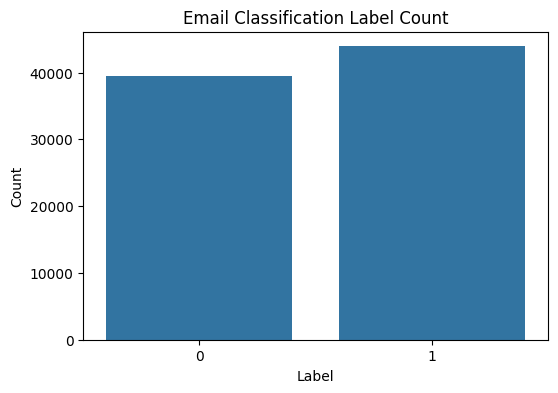

In [ ]:
# Plot the count of class labels
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=Email_Spam_Data)
plt.title("Email Classification Label Count")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

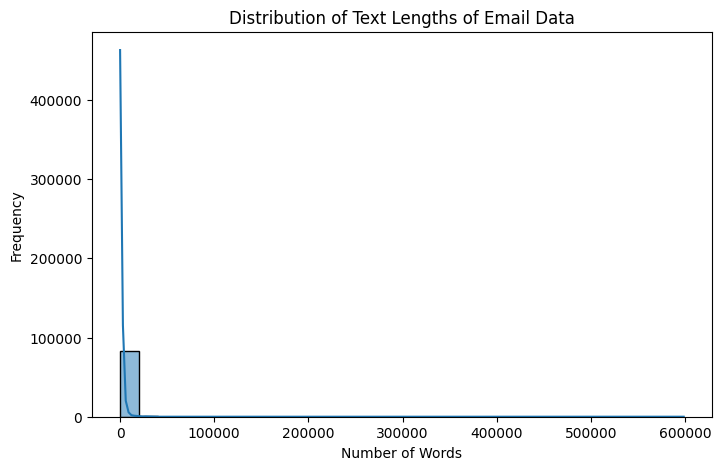

In [ ]:
# Plot histogram of text lengths
plt.figure(figsize=(8, 5))
sns.histplot(Email_Spam_Data['Email_Len'], bins=30, kde=True)
plt.title("Distribution of Text Lengths of Email Data")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

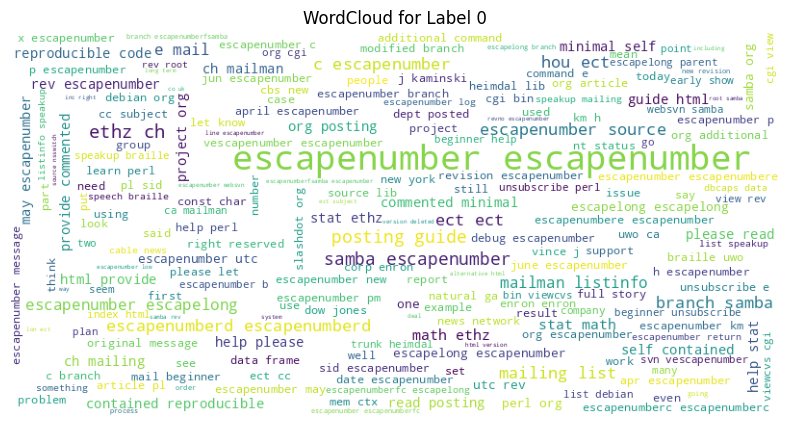

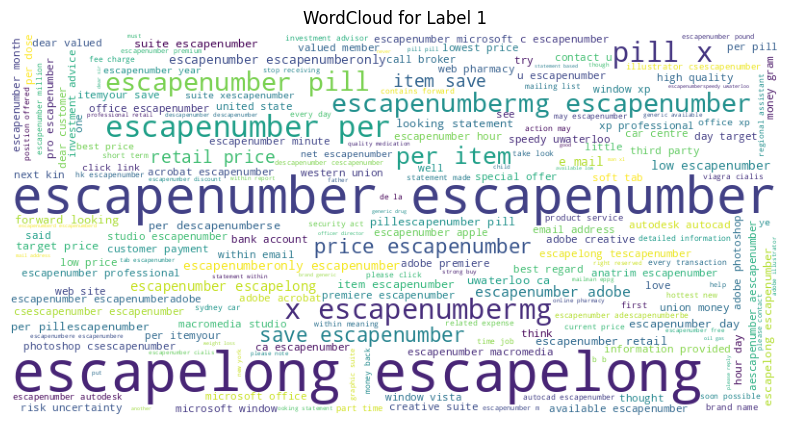

In [ ]:
# Generate WordCloud for each class label
for tgt in sorted(Email_Spam_Data['label'].unique()):
    EM_txt = ' '.join(Email_Spam_Data[Email_Spam_Data['label'] == tgt]['Email_Cleaned'])
    Gen_Wrdcld = WordCloud(width=800, height=400, background_color='white').generate(EM_txt)
    plt.figure(figsize=(10, 5))
    plt.imshow(Gen_Wrdcld)
    plt.axis('off')
    plt.title(f"WordCloud for Label {tgt}")
    plt.show()

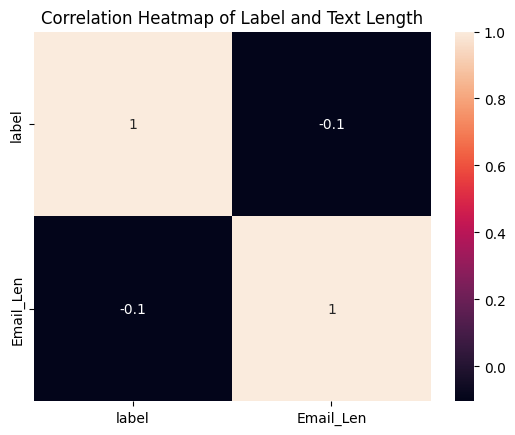

In [ ]:
# Specify columns for correlation analysis
Num_Col_Email = ['label', 'Email_Len']
# Compute correlation matrix
Cormat_EM = Email_Spam_Data[Num_Col_Email].corr()
# Plot heatmap of correlations
sns.heatmap(Cormat_EM, annot=True)
# Add title to the heatmap
plt.title('Correlation Heatmap of Label and Text Length')
plt.show()


In [ ]:
# Split dataset into training and testing sets with stratified labels
Email_Train_df, Email_Test_df = train_test_split(
    Email_Spam_Data, test_size=0.2, random_state=2025, stratify=Email_Spam_Data['label']
)

In [ ]:
# Convert train and test DataFrames to HuggingFace Dataset format
Em_Train_DS = Dataset.from_pandas(Email_Train_df)
Em_Test_DS = Dataset.from_pandas(Email_Test_df)

In [ ]:
# Load BERT tokenizer
Chosen_model_EM = "bert-base-uncased"
Em_Bert_Token = AutoTokenizer.from_pretrained(Chosen_model_EM)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Tokenization function for HuggingFace datasets
def fun_Token_EM(data):
    """
    Tokenizes input text using the loaded tokenizer.Applies padding and
    truncation to ensure uniform input length for transformer models
    like BERT or RoBERTa.

    Parameters:
    data: A batch of examples with a "text" field.

    Returns: Tokenized output with input IDs, attention masks, etc.
    """
    return Em_Bert_Token(data["text"], padding="max_length", truncation=True)


# Apply tokenization to train and test datasets
Em_Train_DS = Em_Train_DS.map(fun_Token_EM, batched=True)
Em_Test_DS = Em_Test_DS.map(fun_Token_EM, batched=True)

Map:   0%|          | 0/66758 [00:00<?, ? examples/s]

Map:   0%|          | 0/16690 [00:00<?, ? examples/s]

In [ ]:
# Load pre-trained model for sequence classification with 2 output labels
Cust_Model_EM = AutoModelForSequenceClassification.from_pretrained(Chosen_model_EM, num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set training parameters for the model
Em_Btch_Size = 64
EM_Log_Steps = len(Em_Train_DS) // Em_Btch_Size
# Get the model name without path prefix
Chosen_model_EM = Chosen_model_EM.split("/")[-1]

In [ ]:
# Define training arguments for model fine-tuning
EM_Trn_Args = TrainingArguments(
    output_dir=f"{Chosen_model_EM}-finetuned-custom", overwrite_output_dir=True,
    learning_rate=2e-5, weight_decay=0.01,per_device_train_batch_size=Em_Btch_Size,
    per_device_eval_batch_size=Em_Btch_Size, push_to_hub=False,
    fp16=torch.cuda.is_available(),logging_steps=EM_Log_Steps,report_to="none")

In [ ]:
# Load accuracy metric from HuggingFace evaluate library
Acc_Met_EM = evaluate.load("accuracy")

# Define function to compute evaluation metrics
def Cal_Metrics_EM(eval_pred):
    """
    Computes accuracy metric for model evaluation.

    Parameters:
    eval_pred : A tuple containing logits of Raw model predictions and
    labels of True labels.

    Returns: Dictionary containing accuracy score.
    """
    EM_Logits, EM_labels = eval_pred
    EM_preds = torch.argmax(torch.tensor(EM_Logits), dim=-1)
    return Acc_Met_EM.compute(predictions=EM_preds, references=EM_labels)

In [ ]:
# Train the model using HuggingFace Trainer API
EM_Trainer_det = Trainer(
    model=Cust_Model_EM,
    args=EM_Trn_Args,
    train_dataset=Em_Train_DS,
    eval_dataset=Em_Test_DS,
    compute_metrics=Cal_Metrics_EM
)
# Start training
EM_Trainer_det.train()

Step,Training Loss
1043,0.063200
2086,0.015600
3129,0.007000


TrainOutput(global_step=3132, training_loss=0.028563513367406795, metrics={'train_runtime': 4603.0992, 'train_samples_per_second': 43.509, 'train_steps_per_second': 0.68, 'total_flos': 5.269430350116864e+16, 'train_loss': 0.028563513367406795, 'epoch': 3.0})

In [ ]:
# Evaluate the trained model on the test set
EM_Model_Eval = EM_Trainer_det.evaluate()
# Print evaluation metrics of the model on Email Spam data
print("Evaluation Results of the Model on Email Spam Data :")
for key, value in EM_Model_Eval.items():
    print(f"{key}: {value:.4f}")

Evaluation Results of the Model on Email Spam Data :
eval_loss: 0.0292
eval_accuracy: 0.9937
eval_runtime: 129.0247
eval_samples_per_second: 129.3550
eval_steps_per_second: 2.0230
epoch: 3.0000


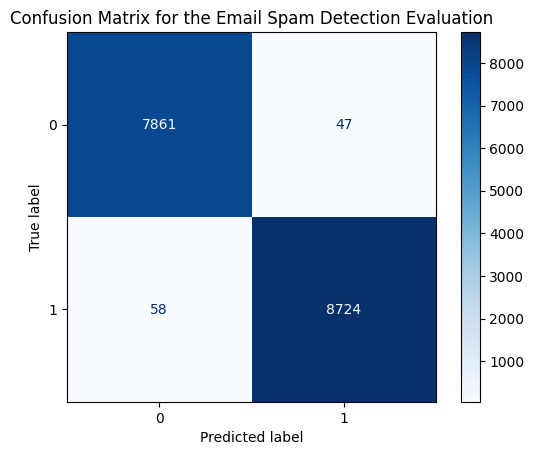

In [ ]:
# Get predictions from the model on test data
EM_Model_Pred = EM_Trainer_det.predict(Em_Test_DS)
Org_Labels = EM_Model_Pred.label_ids
EM_Pred_Labels = torch.argmax(torch.tensor(EM_Model_Pred.predictions), axis=1).numpy()
# Compute and display confusion matrix
Eval_EM_ConfMat = confusion_matrix(Org_Labels, EM_Pred_Labels)
Disp_EM_Confmat = ConfusionMatrixDisplay(confusion_matrix=Eval_EM_ConfMat)
Disp_EM_Confmat.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix for the Email Spam Detection Evaluation")
plt.show()


In [ ]:
# Get raw text from the original test dataset
EM_testing_Samples = Em_Test_DS["text"]
# Display 5 prediction samples with their true and predicted labels
print("\nPredicting the Lables with the Trained Models on Test Data Samples:\n")
for i in range(5):
    print(f"Text: {EM_testing_Samples[i]}")
    print(f"Predicted Label : {EM_Pred_Labels[i]}, True Label: {Org_Labels[i]}")
    print("-" * 60)



Predicting the Lables with the Trained Models on Test Data Samples:

Text: on fri jun escapenumber escapenumber at escapenumber escapenumber escapenumberam escapenumber james peach wrote there's escapenumber related issues in this patch set the first is the bsd style changes for setgroups the second is the darwin specific changes to the order of credential operations if it's darwin specific then i want it split into a darwin specific change the current code intertwines these two parts in two places set sec ctx and pop sec ctx i felt that splitting the credential switch into a separate function made this a lot clearer there is exactly one place where the credential is switched and the credential switching code is not mixed with the security context stack management code the result is credential switching code that is easier to read audit and log sez you the existing code works and works well on all but one class of broken systems bsd please do not modify existing working code just fix 